# Proyecto de Predicción de Valor de Mercado: Rusty Bargain

**Introducción**

El servicio de venta de autos usados Rusty Bargain busca innovar en el mercado automotriz mediante el desarrollo de una aplicación móvil diseñada para atraer nuevos clientes. El núcleo de esta herramienta es permitir que los usuarios descubran de manera rápida y precisa el valor de mercado de su vehículo.

Como científicos de datos, contamos con acceso a un conjunto de datos histórico ``(Alrededor de 350,000 registros)` que incluye especificaciones técnicas, versiones de equipamiento y precios de venta reales. El objetivo principal de este proyecto es construir y evaluar diversos modelos de Machine Learning para determinar cuál ofrece el mejor equilibrio entre precisión y rendimiento técnico.

**Objetivos del Proyecto**

Para cumplir con los estándares de calidad de la aplicación, Rusty Bargain ha definido tres métricas críticas de evaluación:

- Calidad de la predicción: El modelo debe minimizar el error en la estimación del precio para garantizar que el usuario reciba una valoración justa y realista.

- Velocidad de la predicción: Dado que la aplicación se utiliza en tiempo real, el modelo debe ser capaz de procesar los datos de entrada y devolver un resultado casi instantáneamente.

- Tiempo de entrenamiento: Es fundamental que el modelo pueda re-entrenarse de manera eficiente conforme se incorporen nuevos datos al historial de ventas.

**Estructura del Notebook**

Para alcanzar la solución óptima, el trabajo se dividirá en las siguientes etapas:

- Exploración y Preprocesamiento de Datos: Limpieza de valores ausentes, tratamiento de duplicados y codificación de variables categóricas.

- Entrenamiento de Modelos: Implementación de diferentes algoritmos, incluyendo modelos de regresión lineal tradicionales y métodos avanzados de Gradient Boosting (como `LightGBM`, `CatBoost` o `XGBoost`).

- Análisis de Rendimiento: Comparativa detallada de cada modelo basada en el error cuadrático medio (`RMSE`), el tiempo de ejecución y la eficiencia de entrenamiento.

**Nota:** Se pondrá especial énfasis en los algoritmos de potenciación de gradiente, ya que suelen ofrecer el mejor compromiso entre la precisión requerida y la velocidad de respuesta para aplicaciones comerciales.

*Columnas del DataSet*:
- DateCrawled — fecha en la que se descargó el perfil de la base de datos
- VehicleType — tipo de carrocería del vehículo
- RegistrationYear — año de matriculación del vehículo
- Gearbox — tipo de caja de cambios
- Power — potencia (CV)
- Model — modelo del vehículo
- Mileage — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- RegistrationMonth — mes de matriculación del vehículo
- FuelType — tipo de combustible
- Brand — marca del vehículo
- NotRepaired — vehículo con o sin reparación
- DateCreated — fecha de creación del perfil
- NumberOfPictures — número de fotos del vehículo
- PostalCode — código postal del propietario del perfil (usuario)
- LastSeen — fecha de la última vez que el usuario estuvo activo

In [1]:
# librerias

# Data Wrangling
import pandas as pd
import numpy as np
from datetime import datetime

# Eficiency
from time import time

# Visuales
from matplotlib import pyplot
import seaborn as sns
sns.set_style(style='darkgrid')
from IPython.display import display

# ML tools
from sklearn.preprocessing import StandardScaler, TargetEncoder, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# LinearRegression Sklearn:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# CatBoost Regression Model
from catboost import CatBoostRegressor
# XGBoostRegressor
from xgboost import XGBRegressor
# LightGBM Regression Model
from lightgbm import LGBMRegressor

#Export
import json
import joblib

# Load Data
df = pd.read_csv('C:/Users/GaloA/Documents/data_science/boosting/car_data.csv')

# Constants
SEED = 12345

# Tratamiento de Valores Ausentes

In [2]:
# Los valores usentes se hayan en las columnas categoricas, existe la etiqueta "unknown" en las colmnas
# por tanto los valores ausentes se remplazaran por la categoria "no_value" 

df['NotRepaired'] = df['NotRepaired'].fillna('no_value')
df['FuelType'] = df['FuelType'].fillna('no_value')
df['Model'] = df['Model'].fillna('no_value')
df['Gearbox'] = df['Gearbox'].fillna('no_value')
df['VehicleType'] = df['VehicleType'].fillna('no_value')

# Las columnas estan escritas en CamelCase, no cambiare sus nombres.
# Los tipo de datos son adecuados

display(df.info())
display(df.describe())
display(df.sample(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              354369 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
160609,25/03/2016 13:41,13990,small,2010,manual,147,cooper,70000,7,petrol,mini,no,25/03/2016 00:00,0,44866,07/04/2016 14:56


# Tratamiento Columnas Tiempo - Filtro A columna Precios

In [3]:
# Para esta tarea las columnas ['DateCrawled','DateCreated','LastSeen','RegistrationMonth']. Aportan informacion de actividad del
# usuario pero no aporta informacion al precio del auto. Estas columnas no aportan valor y por eso seran descartadas:
time_columns = ['DateCrawled','DateCreated','LastSeen','RegistrationMonth']
df = df.drop(labels=time_columns,axis=1)

# Ademas en lugar de usar la fecha de registro (e.j. 1970,1998,etc...) Haremos que el modelo aprende como
# el paso de tiempo afecta el precio, la mejor manera es sustituyendo fecha por tiempo transurrido.
# o sea: fecha actual - fecha_registro
current_year = datetime.now().year
df['Age'] = current_year - df['RegistrationYear'] # Creo la columna antiguedad del auto
df = df[~(df['RegistrationYear'] > current_year)] # Elimino los registros con edad incoherente (Se eliminaron 105 observaciones)
df = df.drop(labels=['RegistrationYear','NumberOfPictures','PostalCode'],axis=1)
# Aqui elimino tambien "NumberOfPictures,PostalCode" por su nula correlacion con precio: 
# Mas adelante se explica mucho mejor esta decision.
# Lo mismo para el codigo postal pues es informacion del usuario pero no del valor del auto.

In [4]:
# Filtrar precios menores a 100 euros. Posibles errores. Valorar correctamente justifica eliminar estos precios
# irreales para un auto.
# Tambien eliminamos los autos con atiguedad mayor a 150.
dimension_antes = df.shape[0]
df = df[df['Price'] > 100].copy()
df = df[df['Age'] < 150].copy()
dimension_despues = df.shape[0]
    
print(f"Registros eliminados: {dimension_antes - dimension_despues}")
print()
display(df.head(1))

print('Power',df['Power'].min(),df['Power'].max())
print('Mileage',df['Mileage'].min(),df['Mileage'].max())
print('Age',df['Age'].min(),df['Age'].max())


Registros eliminados: 14351



,Price,VehicleType,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,Age
0,480,no_value,manual,0,golf,150000,petrol,volkswagen,no_value,32


Power 0 20000
Mileage 5000 150000
Age 6 115


**NOTA:**

En total se eliminaron 6 columnas y se agregó una nueva `Antiguedad`. Con respecto a las filas se perideron alrededor de `14,400` registros un `0.04%` con respecto al total. Se dio tratamiento a los valores `NaN` presentes en las columnas categoricas y ademas se descartó el uso de columnas tiempo que median actividad de usuario en la plataforma pero que no aportaban valor al valor del carro.

# Exploratory Data Analysis

In [5]:
# Este DataFrame cuenta con muchos valores unicos en las columnas categoricas de texto. 
# Para evitar gran cardinalidad debemos identificar esas columnas y darles un tratamiento apropiado:

# El metodo .select_dtype() es muy util para identificar columnas de un tipo especifico y evitar nombralas una por una.
categoric_columns = df.select_dtypes(include='object').columns.tolist()
print(categoric_columns)

# De misma manera identificare las columnas numericas, quitando la variable target "Price" en este caso:
numeric_columns = df.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_columns.remove('Price')
print(numeric_columns)

# Nota Importante, para los modelos "CatBoost" no es necesario el encoding para las columnas categoricas,
# Pero como vamos a probar diferentes modelos, haremos etiquetado manual con "TargetEncoding" - Scikit-Learn

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
['Power', 'Mileage', 'Age']


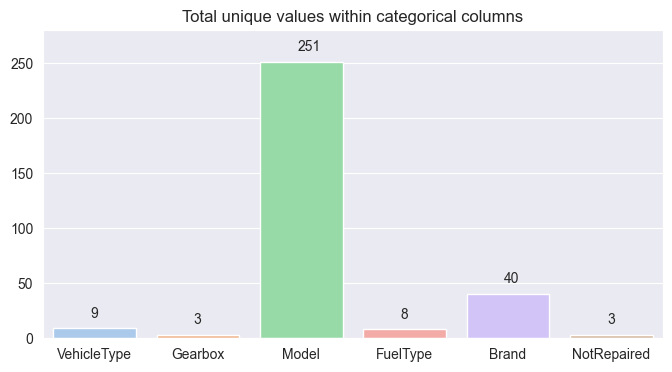

In [6]:
# Veamos la cantidad de valores unicos por columna categorica:
y_axis = []
for column in categoric_columns:
    y_axis.append(df[column].nunique())

pyplot.figure(figsize=(8,4))
sns.barplot(x=categoric_columns,y=y_axis,hue=categoric_columns,palette='pastel')
pyplot.ylim(0,280)
x = -0.04
for y in y_axis:
    pyplot.annotate(text=f'{y}',xy=(x,y+10))
    x += 1
pyplot.title('Total unique values within categorical columns')
pyplot.show()
# Vemos que no contamos con alguna categoria binaria, usar "TargetEncoding" es la mejor opcion para etiquetar estas columnas
# Y mantener bajo el conteo de columnas que se podria crear con "One-Hot-Encoding"

In [7]:
# Esta linea exporta los valores unicos de las columnas categoricas.
unique_values = {}
for col in categoric_columns:
    values = df[col].unique().tolist()
    unique_values[col] = values

with open('unique_values_columns.json','w',encoding='utf-8') as f:
    json.dump(unique_values,f,indent=4,ensure_ascii=False)

**Conclusion Para columnas categoricas:** 

- Se utilizara `TargetEncoding`. Excepcion para `CatBoost`.

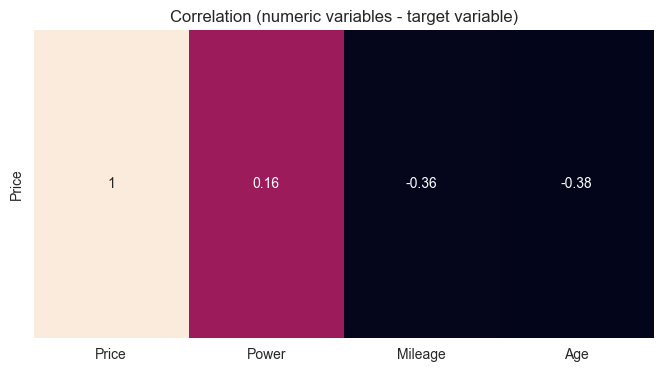

In [8]:
# Exploracion de datos numericos. En estos casos la matrix de correlacion ayuda a visualizar 
# estas columnas de manera eficiente. 

# En mi caso encontre relacion NaN para la columna NumberOfPictres. Debido a que es una columna de valor constante.
# En casos como estos una variable constante no genera cambios en la variable objetivo y es util eliminarla.
# Reduce el ruido, reduce tiempo de entrenamiento, evitar errores de calculo (e.j NaN).

numbers_correlation = df[numeric_columns+['Price']].corr()
cm = numbers_correlation[['Price']].sort_values(by='Price',ascending=False)
cm = cm.T # Transpongo la matrix para que se vea en formato largo
pyplot.figure(figsize=(8,4))
sns.heatmap(data=cm,annot=True,cbar=False)
pyplot.title('Correlation (numeric variables - target variable)')
pyplot.show()

**Nota:**
- Mediante la matriz de correlación encontré como "`NumberOfPictures`" es constante, por tanto no aporta a la predicción y su valor de correlación es NaN. Acciones: Se eliminó esa columna del DataFrame.
- Con respecto a la columna `PostalCode` se eliminó dado que su relacion era de `0.076`. Ademas que esta metrica solo evalua la ubicación del usuario cosa que no aporta valor a la predicción.
- Tambien descumbrimos que el formato de "`RegistrationYear`" tiene poca correlación con la variable objetivo, mediante el cálculo de la diferencia:  $$ age = current_{date} - registration_{date} $$ Pasamos de valores altos $$ 2025 - 1999 = \text {valores pequeños: } 26 $$ Lo cual le facilita al modelo aprender la relación inversa. El tiempo afecta al costo (Precio). Correlación: `-0.24` en el mapa de calor.

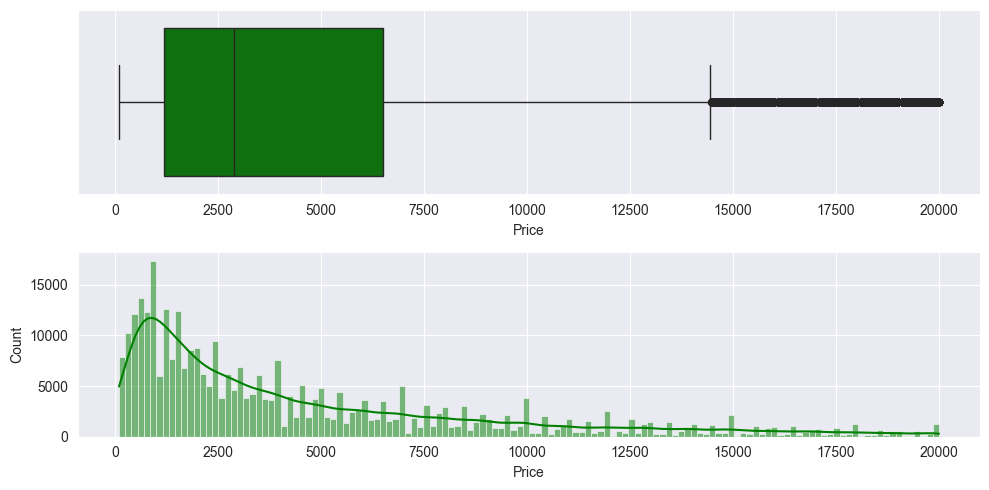

,Median,Mean,Count Of Cero Prices
Values,2900,4603,0


In [9]:
pyplot.figure(figsize=(10,5))

pyplot.subplot(211)
sns.boxplot(df['Price'],orient='h',color='green',fliersize=4.5)

pyplot.subplot(212)
sns.histplot(df['Price'],kde=True,color='green')

pyplot.tight_layout()
pyplot.show()

ceros = len(df[df['Price']==0])
media = df['Price'].mean()
mediana = df['Price'].median()

distribution = pd.DataFrame(data=[[mediana,media,ceros]],index=['Values'],columns=['Median','Mean','Count Of Cero Prices'])
display(distribution.style.format("{:.0f}"))

**Nota Columna Precio:**

- La distribción tiende a la derecha. (Trataremos de normalizar esta curva).
- (Valores atípicos para precios extremos). Esto se ve perfecto en el histograma y el boxplot.
- Dado que se filtraron precios irrealeas de valoración para autos. No hay registros de $$ \text{precio} < 100 $$ 
- Para tratar estos valores que alejan a la media `4603` de la mediana `2900` se utilizará $$log(1 + y)$$
    - 1. Normalizar la distribución.
    - 2. Previene el uso de valores 0. A pesar de que ya fueron filtrados.

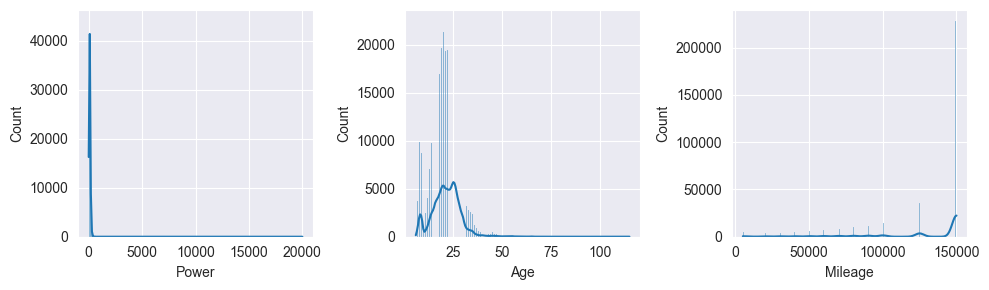

In [10]:
# Observacion rapida a la distribucion de el resto de variables numericas:
pyplot.figure(figsize=(10,3))

pyplot.subplot(131)
sns.histplot(df['Power'],kde=True)
pyplot.subplot(132)
sns.histplot(df['Age'],kde=True)
pyplot.subplot(133)
sns.histplot(df['Mileage'],kde=True)
pyplot.tight_layout()
pyplot.show()

**Nota:**

- El mismo caso de distribución larga a la derecha del histograma para `Power` y `Age`. Esto lo solucionaremos con: $$log(1 + y)$$
- Para `Mileage` se utilizara `PowerTransformer`, `hyperparameter` = `method = 'yeo-johnson'`. El cual fuerza la distribución a la izquierda.

# Procesamiento de Datos

In [11]:
# Veamos el df final completo antes de continuar con el proceso de datos:
display(df.head(1))

# Esta variable determina el orden de las columnas con las que se entrenara el modelo:
COLUMNS_ORDER = categoric_columns + numeric_columns

# Definimos matrices X,Y
features = df[COLUMNS_ORDER]
target = df['Price']
display(features.head(1))
display(target.head(1))


,Price,VehicleType,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,Age
0,480,no_value,manual,0,golf,150000,petrol,volkswagen,no_value,32


,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,Power,Mileage,Age
0,no_value,manual,golf,petrol,volkswagen,no_value,0,150000,32


0    480
Name: Price, dtype: int64

In [12]:
# Obtenemos set de entrenaminento y de prueba:
train_x, test_x, train_y, test_y = train_test_split(features,target,random_state=SEED,test_size=0.20)

print(f'Entrenamiento Dimensiones {train_x.shape,train_y.shape}')
print(f'Prueba Dimensiones {test_x.shape,test_y.shape}')

Entrenamiento Dimensiones ((271930, 9), (271930,))
Prueba Dimensiones ((67983, 9), (67983,))


In [13]:
# 1. Aplicacion de logaritmo a (Price) (Power, Age)
LOGARITHM_COLUMNS = ['Power','Age']

# 2. Conversion de target:
train_y = np.log1p(train_y)

# 3. Conversion de las columnas features:
for col  in LOGARITHM_COLUMNS:
    train_x[col] = np.log1p(train_x[col])
    test_x[col] = np.log1p(test_x[col])

# 2. Variable con cola a la IZQUIERDA (Mileage)
# Usaremos PowerTransformer para que Scikit-Learn ajuste la distribución
pt = PowerTransformer(method='yeo-johnson')

# PowerTransformer ajusta y transforma al mismo tiempo
train_x[['Mileage']] = pt.fit_transform(train_x[['Mileage']])
test_x[['Mileage']] = pt.transform(test_x[['Mileage']])

display(train_x.head(1))
display(train_y.head(1))

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,Power,Mileage,Age
228456,sedan,manual,a6,gasoline,audi,yes,0.0,0.65489,3.218876


228456    7.783641
Name: Price, dtype: float64

In [14]:
# Respaldo de la matrix de caracteristicas en crudo: (Util para CatBoost)
train_x_raw = train_x.copy()
test_x_raw = test_x.copy()

# Codificamos las columnas categoricas:
encoder = TargetEncoder(categories='auto',target_type='continuous',smooth='auto',cv=5,shuffle=True)
train_x[categoric_columns] = encoder.fit_transform(train_x[categoric_columns],train_y)
test_x[categoric_columns] = encoder.transform(test_x[categoric_columns])

In [15]:
# Escalado de datos:
scaler = StandardScaler()
train_x[numeric_columns] = scaler.fit_transform(train_x[numeric_columns])
test_x[numeric_columns] = scaler.transform(test_x[numeric_columns])

# Escalo los datos para la matrix SIN encoding
train_x_raw[numeric_columns] = scaler.transform(train_x_raw[numeric_columns])
test_x_raw[numeric_columns] = scaler.transform(test_x_raw[numeric_columns])

print('Matriz de Caracteristicas final:')
display(train_x.head())
print('Matriz de Caracteristicas final SIN encoding:')
display(train_x_raw.head())

Matriz de Caracteristicas final:


,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,Power,Mileage,Age
228456,8.013220,7.810091,8.470564,8.496444,8.346198,7.050120,-2.847885,0.654890,0.433392
261363,7.419528,7.809787,7.325621,7.719192,7.911040,8.163526,-2.847885,0.654890,0.659502
226590,7.328178,7.810091,7.479696,7.720523,7.789296,8.163600,0.351628,-1.668011,-2.258652
169903,7.422079,7.810391,6.966701,7.720394,7.661250,8.164836,-0.270930,0.654890,0.766349
100125,8.053794,8.476092,8.323171,7.718877,8.327712,8.164116,0.797545,0.654890,-0.078855


Matriz de Caracteristicas final SIN encoding:


,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,Power,Mileage,Age
228456,sedan,manual,a6,gasoline,audi,yes,-2.847885,0.654890,0.433392
261363,small,manual,polo,petrol,volkswagen,no,-2.847885,0.654890,0.659502
226590,no_value,manual,civic,petrol,honda,no,0.351628,-1.668011,-2.258652
169903,small,manual,1_reihe,petrol,peugeot,no,-0.270930,0.654890,0.766349
100125,wagon,auto,e_klasse,petrol,mercedes_benz,no,0.797545,0.654890,-0.078855


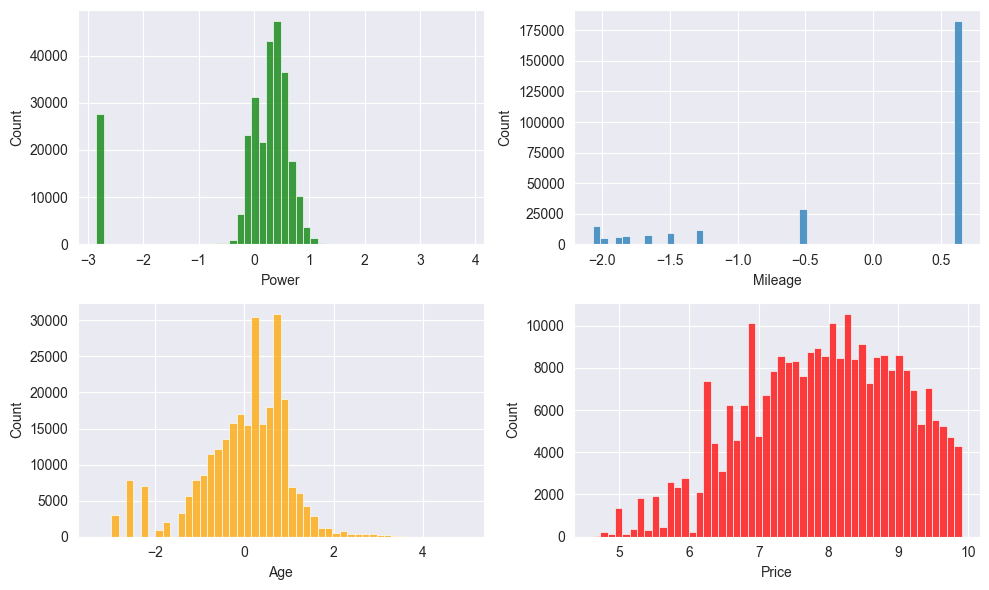

In [16]:
# Distribcion de variables numericas despues de ajustarlas:

pyplot.figure(figsize=(10,6))

pyplot.subplot(221)
sns.histplot(train_x['Power'],color='green',bins=50)

pyplot.subplot(222)
sns.histplot(train_x['Mileage'],bins=50)

pyplot.subplot(223)
sns.histplot(train_x['Age'],color='orange',bins=50)

pyplot.subplot(224)
sns.histplot(train_y,color='red',bins=50)

pyplot.tight_layout()
pyplot.show()

**Nota:**

- Podemos notar que las variables con distribución a la derecha se han suavizado o en el caso de price se perdió su extensión de valores altos. También como `PowerTransformer(method='yeo-johnson')` redujó la extension de cola a la izquierda del histograma.

# Metrica de Evaluacion

In [17]:
# Defino la metrica de evaluacion:
def evaluar(y_true,y_pred,color='viridis'):
    score_rmse = np.sqrt(mean_squared_error(y_true=y_true,y_pred=y_pred))
    score_r2 = r2_score(y_true=y_true,y_pred=y_pred)
    score_abs = mean_absolute_error(y_true=y_true,y_pred=y_pred)

    pyplot.figure(figsize=(12,3))
    sns.histplot(data=[y_true,y_pred],palette=color,kde=True)
    pyplot.xlim(0,30000)
    pyplot.legend(['Real Price','Predicted Price'])
    pyplot.show()
    
    results = pd.DataFrame([[score_rmse,score_r2,score_abs]],columns=['RMSE','R2','MAE'],index=['Results'])
    display(results.style.format("{:.2f}"))

# Baseline LinerRegression

Entrenando
Tiempo de entrenamiento 0.06
Tiempo de prediccion 0.00
Tiempo total en entrenar y predecir 0.06
----------

Puntajes para Set De Entrenamiento


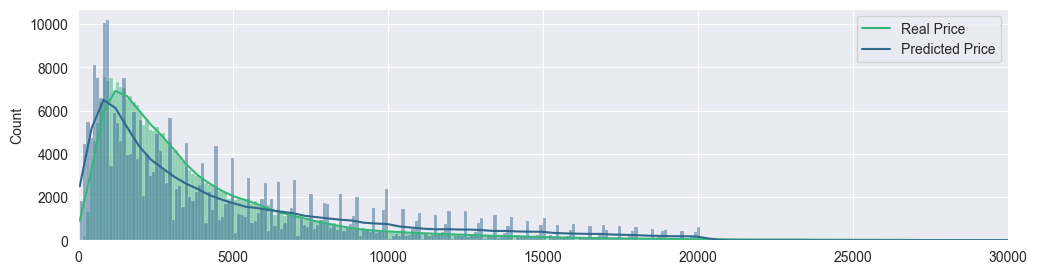

,RMSE,R2,MAE
Results,3236.36,0.49,1962.22



Puntajes para Set De Prueba


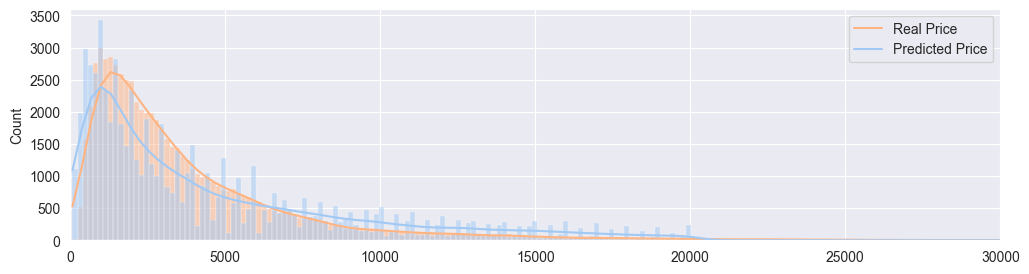

,RMSE,R2,MAE
Results,3220.83,0.49,1958.04


In [18]:
# Regresion lineal simple (Base de Referencia)
lineal = LinearRegression()

start_train = time()
lineal.fit(train_x,train_y)
print('Entrenando')
end_train = time()

start_pred = time()
log_predictions = lineal.predict(test_x)
end_pred = time()

time_train = end_train-start_train
time_test = end_pred-start_pred
print(f'Tiempo de entrenamiento {time_train:.2f}')
print(f'Tiempo de prediccion {time_test:.2f}')
print(f'Tiempo total en entrenar y predecir {(time_train+time_test):.2f}')
print('-'*10)
print()

# Evaluar sobreajuste y modelo con comportamientos nuevos
log_train_pred = lineal.predict(train_x)
predictions = np.expm1(log_predictions)

print('Puntajes para Set De Entrenamiento')
evaluar(y_true=np.expm1(train_y),y_pred=np.expm1(log_train_pred))
print()

print('Puntajes para Set De Prueba')
evaluar(test_y,predictions,color='pastel')

**Nota sobre el modelo base:**

- Se puede ver como este modelo `RegresionLineal` de `Scikit-Learn` es capaz de identificar la tendencia, predecir precios, primero sobre-estima y despues sub-estima. Ademas confirmamos que los datos se trataron adecuadamente y que no hay sobreajuste. 
- Valor R2 = `49%` en ambos conjuntos.

# Entrenamiento de Modelos con Boosting: (Busqueda de Eficiencia y Precisión)

Entrenando
Tiempo de entrenamiento 27.98
Tiempo de prediccion 0.16
Tiempo total en entrenar y predecir 28.14
----------


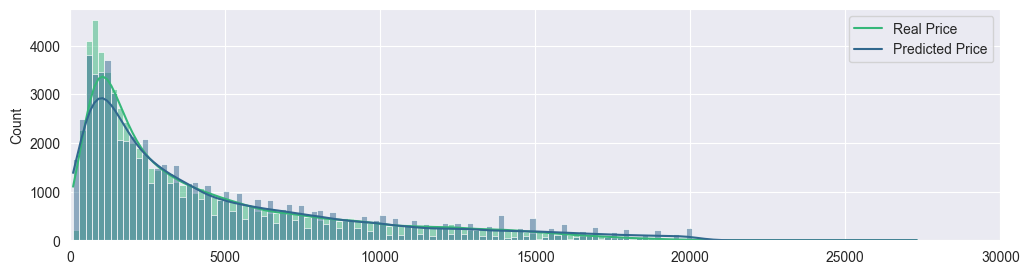

,RMSE,R2,MAE
Results,1746.30,0.85,1038.80


In [22]:
# Modelo 1 : CatBoostRegressor

# Documentacion:
# https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329/
# https://www.geeksforgeeks.org/machine-learning/regression-using-catboost/
# https://catboost.ai/docs/en/concepts/python-reference_catboostregressor

catboost = CatBoostRegressor(iterations=250,loss_function='RMSE',learning_rate=0.5,cat_features=categoric_columns)
print('Entrenando')
start_train = time()
catboost.fit(train_x_raw,train_y,verbose=0)
end_train = time()

start_pred = time()
log_predictions = catboost.predict(test_x_raw)
end_pred = time()

time_train = end_train-start_train
time_test = end_pred-start_pred
print(f'Tiempo de entrenamiento {time_train:.2f}')
print(f'Tiempo de prediccion {time_test:.2f}')
print(f'Tiempo total en entrenar y predecir {(time_train+time_test):.2f}')
print('-'*10)

evaluar(y_true=test_y,y_pred=np.expm1(log_predictions))

Entrenando
Tiempo de entrenamiento 199.23
Tiempo de prediccion 6.71
Tiempo total en entrenar y predecir 205.94
----------


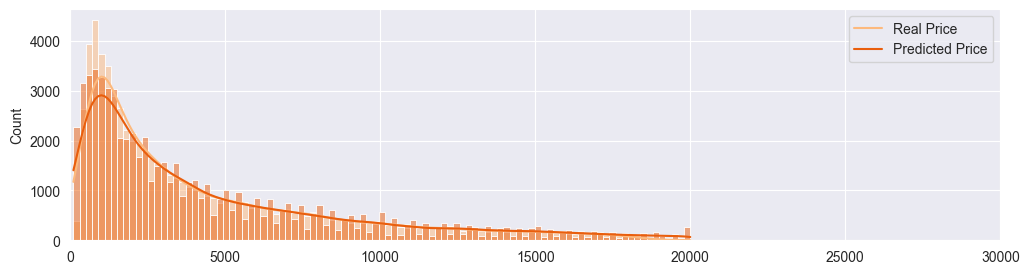

,RMSE,R2,MAE
Results,1656.61,0.86,969.64


In [23]:
# Modelo 2 : RandomForestRegressor

random_forest_regressor = RandomForestRegressor(random_state=SEED,n_estimators=200)
print('Entrenando')
start_train = time()
random_forest_regressor.fit(train_x,train_y)
end_train = time()

start_pred = time()
log_predictions = random_forest_regressor.predict(test_x)
end_pred = time()

time_train = end_train-start_train
time_test = end_pred-start_pred
print(f'Tiempo de entrenamiento {time_train:.2f}')
print(f'Tiempo de prediccion {time_test:.2f}')
print(f'Tiempo total en entrenar y predecir {(time_train+time_test):.2f}')
print('-'*10)

predictions_rfr = np.expm1(log_predictions)
evaluar(y_true=test_y,y_pred=predictions_rfr,color='Oranges_r')


Entrenando
Tiempo de entrenamiento 2.40
Tiempo de prediccion 0.09
Tiempo total en entrenar y predecir 2.49
----------


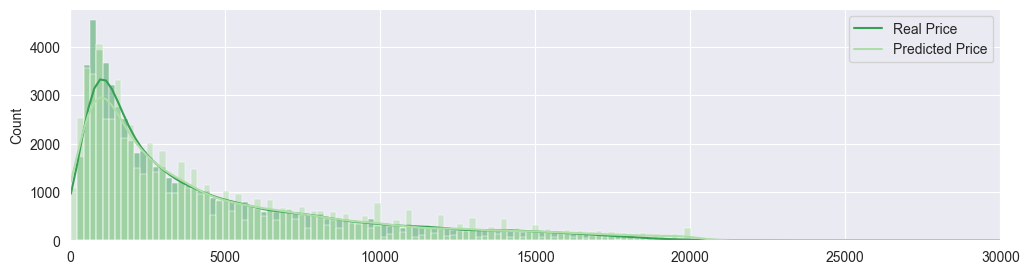

,RMSE,R2,MAE
Results,1712.29,0.86,1003.83


In [34]:
# Modelo 3 : XGBoostRegresor

# Documentacion:
# https://www.geeksforgeeks.org/machine-learning/xgboost-for-regression/
# https://xgboost.readthedocs.io/en/stable/python/python_api.html 
# (Seccion: class xgboost.XGBRegressor(*, objective='reg:squarederror', **kwargs)

xgboost = XGBRegressor(objective='reg:squarederror',random_state=SEED,n_estimators=380,max_depth=8)

print('Entrenando')
start_train = time()
xgboost.fit(train_x,train_y)
end_train = time()

start_pred = time()
log_predictions = xgboost.predict(test_x)
end_pred = time()

time_train = end_train-start_train
time_test = end_pred-start_pred
print(f'Tiempo de entrenamiento {time_train:.2f}')
print(f'Tiempo de prediccion {time_test:.2f}')
print(f'Tiempo total en entrenar y predecir {(time_train+time_test):.2f}')
print('-'*10)

evaluar(y_true=test_y,y_pred=np.expm1(log_predictions),color='Greens')

Entrenando
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 271930, number of used features: 9
[LightGBM] [Info] Start training from score 7.912696
Tiempo de entrenamiento 1.59
Tiempo de prediccion 0.25
Tiempo total en entrenar y predecir 1.84
----------


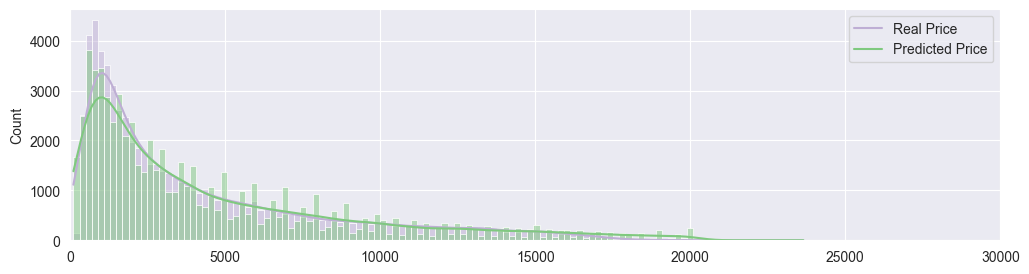

,RMSE,R2,MAE
Results,1762.82,0.85,1056.77


In [50]:
# Modelo 4 : LGBMRegressor

# Documentacion:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
# https://www.geeksforgeeks.org/machine-learning/regression-using-lightgbm/

lgbm = LGBMRegressor(metric='rmse',boosting_type='gbdt',n_estimators=500,objective ='regression',random_state=SEED,learning_rate=0.1)

print('Entrenando')
start_train = time()
lgbm.fit(train_x,train_y)
end_train = time()

start_pred = time()
log_predictions = lgbm.predict(test_x)
end_pred = time()

time_train = end_train-start_train
time_test = end_pred-start_pred
print(f'Tiempo de entrenamiento {time_train:.2f}')
print(f'Tiempo de prediccion {time_test:.2f}')
print(f'Tiempo total en entrenar y predecir {(time_train+time_test):.2f}')
print('-'*10)

evaluar(y_true=test_y,y_pred=np.expm1(log_predictions),color='Accent')

# Conclusiones del Proyecto: Predicción de Precios de Vehículos

1. Preprocesamiento e Ingeniería de Datos: La calidad de las predicciones aumentó drásticamente gracias a un tratamiento refinado de los datos:
    - Limpieza Estratégica: Se eliminaron variables con baja correlación y se filtraron registros con precios irreales (inferiores a $100$ Euros). Esta acción redujo el sesgo y permitió al modelo aprender sobre transacciones comerciales legítimas, elevando el $R^2$ general en aproximadamente un `5-7%`.
    - Transformaciones Matemáticas: El uso de `log1p` para mitigar el sesgo a la derecha y `PowerTransformer` para normalizar `Mileage` permitió que algoritmos sensibles a la distribución (como la `Regresión Lineal`) mejoraran su capacidad predictiva.
    - Gestión de Cardinalidad: Mediante `TargetEncoding`, se transformaron las variables categóricas preservando la información de las etiquetas sin disparar la dimensionalidad del dataset.
2. Validación y Robustez
    - Se confirmó la estabilidad del sistema mediante la comparación de entornos:
    - Ausencia de Sobreajuste: La estrecha brecha entre las métricas de entrenamiento y prueba demuestra que el modelo no ha memorizado los datos, sino que ha aprendido patrones generalizables para nuevos usuarios de la aplicación.
3. Benchmarking de Modelos
    - La competencia entre algoritmos arrojó resultados altamente competitivos tras la limpieza del dataset: Modelo Base (`Linear Regression`): Alcanzó un $R^2 = 0.49$, estableciendo un estándar sólido.
    - Modelos de Gradient Boosting (`XGBoost`, `LGBM`, `CatBoost`): Lograron un desempeño excepcional y consistente, situándose en un rango $R^2 = (0.84 , 0.86)$ pero con mayor error en RMSE.
    - Modelo Ganador (`RandomForestRegressor`): Se consolidó como el más preciso con un $R^2 = 0.86$.
4. Selección Final: Equilibrio entre Precisión y Negocio 

Tras analizar las tres métricas críticas de Rusty Bargain (calidad, velocidad y entrenamiento), se concluye:
- Precisión Superior: El `RandomForestRegressor` es el modelo elegido. Su Error Medio Absoluto `(MAE)` de $970$ Euros garantiza que el usuario reciba una valoración con un margen de error inferior a los $1,000$ euros, cumpliendo con la promesa de una "valoración justa".
- Rendimiento Técnico: Aunque el tiempo de predicción es de 6.81 segundos, la ganancia en confianza del usuario (un `2%` extra de $R^2$ sobre el Boosting) justifica el tiempo de procesamiento.
- Confianza: Un $R^2 = 0.86$ representa el punto óptimo de madurez del modelo, ofreciendo una herramienta fiable para atraer y retener clientes en la plataforma móvil.

In [51]:
# Exportacion de elementos para despliegue:
metadata = {
    'seed':SEED,
    'categoric_columns':categoric_columns,
    'numeric_columns':numeric_columns,
    'columns_order':COLUMNS_ORDER,
    'logarithm_columns':LOGARITHM_COLUMNS,
    'power_transformer_columns':'Mileage',
    'n_estimators':200
}

with open('metadata.json','w',encoding='utf-8') as f:
    json.dump(metadata,f,indent=4,ensure_ascii=False)

joblib.dump(pt,'PowerTranformer.pkl',compress=3)
joblib.dump(encoder,'TargetEncoder.pkl',compress=3)
joblib.dump(scaler,'StandardScaler.pkl',compress=3)

joblib.dump(random_forest_regressor,'RandomForestRegressor.pkl',compress=3)

['RandomForestRegressor.pkl']

In [52]:
# Exportacion del comportamiento del modelo
display(test_y.isnull().sum())
print(np.sum(np.isnan(predictions_rfr)))

performance = pd.DataFrame(data=test_y)
performance = performance.reset_index(drop=True)
performance = pd.concat([performance,pd.Series(predictions_rfr)],axis=1)
performance.rename(columns={0:'Predictions'},inplace=True)

performance.to_csv('performance_data.csv',index=False)

np.int64(0)

0
